Plot Fig. 2e and 2i

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.colors import BoundaryNorm, Normalize

from CP4.utils.make_shapes import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.a1_make_var_field import *
from CP4.make_composites.b1_make_var_field_anomaly import load_composite_mean_ano_field
from CP4.make_composites.significance.b_compute_var_field_significance import load_composite_significance_pvalues
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
ds='CP4A'
res=4
var_ref='twb'
var='twb'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
lat_range=[2., 12.]
lon_range=[-8., 10.]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.  # km2
max_hw_size=1000000.  # km2
sw=[4., 4.]
tw=[-72, 72]
samtime=[19, 19]
n_days=3
meth='cc3d'
cnty=26
length=25.  # km
pvalue=0.01
flabel='e'

In [14]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

lat_min = lat_range[0]
lat_max = lat_range[1]
assert lat_min < lat_max, "incorrect latitude range"
lon_min = lon_range[0]
lon_max = lon_range[1]
assert lon_min < lon_max, "incorrect longitude range"

if (lat_range == [-6.,6.]) and (lon_range == [14.,26.]):
    ttl = 'CAfr'
elif (lat_range == [2.,12.]) and (lon_range == [-8.,10.]):
    ttl = 'Guinea'

var_ = 'Twb'

In [6]:
#~ Get data

vardata = load_composite_var(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

varhclim = load_composite_var_clim(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

ds_ano = load_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty)

pvalues = load_composite_significance_pvalues(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty)

In [8]:
#~ Treat data

tw_before = tw[1]+samtime[0]
tw_after = tw[1]+samtime[1]

varhclim_time = varhclim[:,tw_before:tw_after+1,:,:].mean(axis=1)
varhclim_mean = np.nanmean(varhclim_time, axis=0) # mean across events
varhclim_med = np.nanmedian(varhclim_time, axis=0) # median across events

var_hhee_ano_mean = np.nanmean(ds_ano.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(ds_ano.values, axis=0) # median across events

varhclim_2plot = varhclim_mean
var_hhee_ano_2plot = var_hhee_ano_mean

varhclimmean = np.nanmean(varhclim_2plot)  # spatial mean
varhclimmed = np.nanmedian(varhclim_2plot)
varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)

ncells = length / res
assert (ncells < varhclim_mean.shape[0]) and (ncells < varhclim_mean.shape[1]), 'Length scale larger than spatial window!'

n_hhee = varhclim.shape[0]

xs = np.linspace(-varhclim.shape[2]/2, varhclim.shape[2]/2, varhclim.shape[2])
ys = np.linspace(-varhclim.shape[3]/2, varhclim.shape[3]/2, varhclim.shape[3])

xc = (xs[-1]-xs[0])/2+xs[0]
yc = (ys[-1]-ys[0])/2+ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / res  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values
disc_mask = np.broadcast_to(distloc <= r, ds_ano.shape)

vals_clim_disc = ma.masked_array(varhclim_time, ~disc_mask)    # mask: True = masked
vals_clim_disc = ma.filled(vals_clim_disc, fill_value=np.nan)
vals_clim_disc_med = np.nanmedian(vals_clim_disc, axis=0) # median across events
vals_clim_disc_mean = np.nanmean(vals_clim_disc_med)  # spatial mean

vals_ano_disc = ma.masked_array(ds_ano.values, ~disc_mask)
vals_ano_disc = ma.filled(vals_ano_disc, fill_value=np.nan)
vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # mean across events
vals_ano_disc_mean = np.nanmean(vals_ano_disc_med)  # spatial mean

pvalues_ = pvalues.where(pvalues > pvalue, np.nan)
pvalues_.values[~np.isnan(pvalues_)] = 1

/tmp/ipykernel_188852/3474855003.py:46: RuntimeWarning: Mean of empty slice
  vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # mean across events


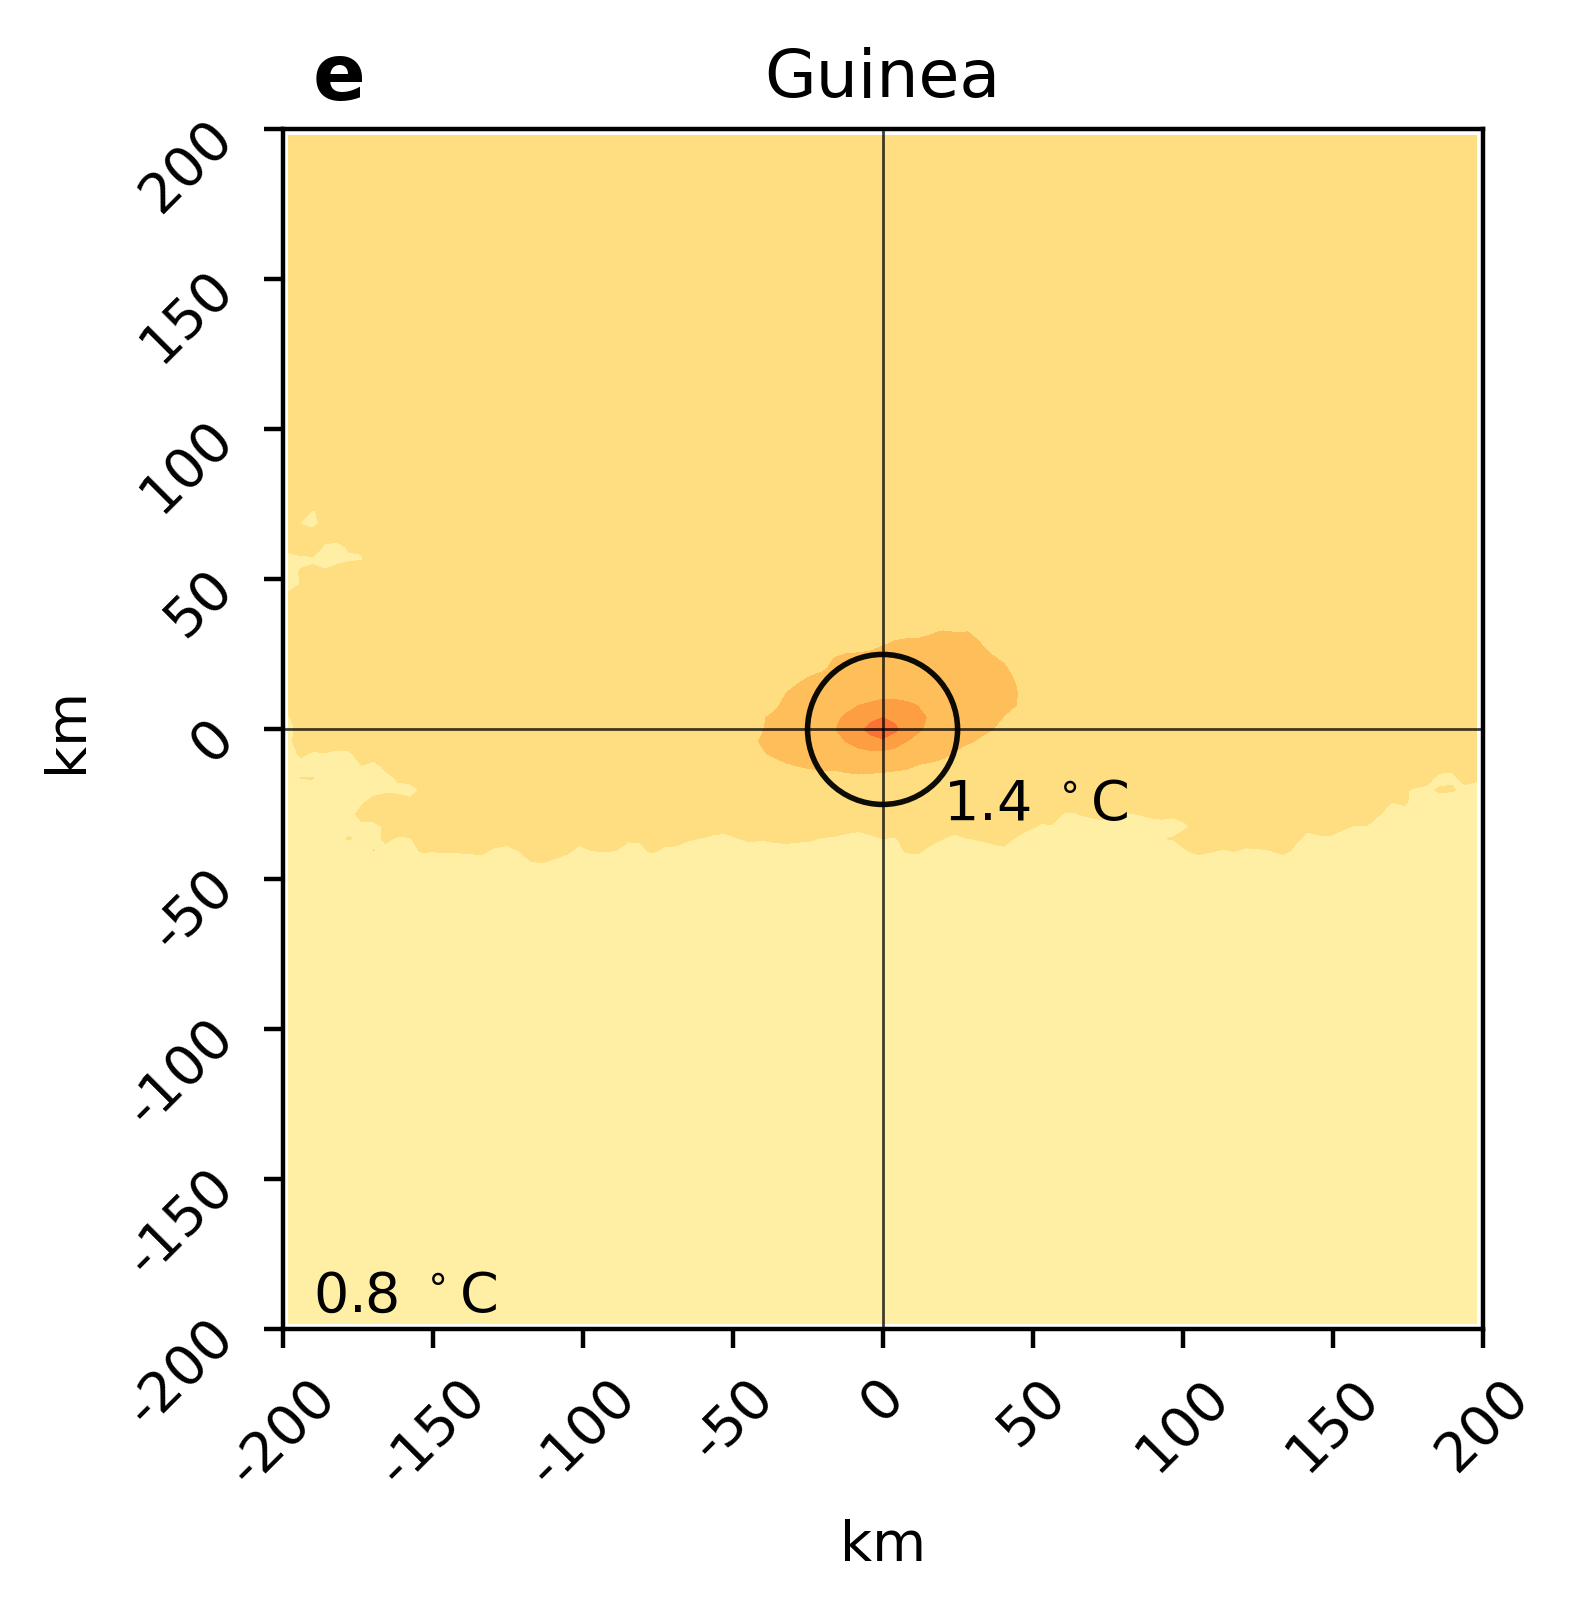

In [17]:
#~ Plot

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor='k', linewidth=1, alpha=0.95)

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / res
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / res

cmap = cmaps[var]
cmap = plt.get_cmap(cmap)

anomin = clim_vars_ano[var_ref][var][0]
anomax = clim_vars_ano[var_ref][var][1]

bounds = np.linspace(anomin, anomax, 11)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)


fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)

p_ano = ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap)

ax_ano.contourf(xs, ys, pvalues_, hatches=['.'], colors='none')  # , alpha=0.5

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)
ax_ano.text(0.55, 0.425, '%.1f $^\circ$C'%vals_ano_disc_mean, transform=ax_ano.transAxes)  # (xc)/len(xs)+0.05, (yc-r-2)/le>
ax_ano.text(0.025, 0.015, '%.1f $^\circ$C'%varanomean, transform=ax_ano.transAxes)

ax_ano.add_patch(circle_ano)

ax_ano.axhline(yc, 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline(xc, 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)
ax_ano.set_title(ttl)

fig_ano.set_size_inches(4., 4.)